# Neural Efficiency Analysis
In this notebook we explore the neural efficiency metric with quantized models.

In [17]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import warnings


# import modules from RN08 model
module_path = os.path.abspath(os.path.join('../../workspace/models/rn08/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import rn08

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ
import autoencoder_datamodule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from neural_efficiency import NeuralEfficiency



## Utility methods

In [18]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()
    
def plot_neural_efficiency_per_layer(neural_efficiency_values, 
                                     title, 
                                     x_label='Layers', 
                                     y_label='Efficiency'):
    plt.figure(figsize=(12,6))
    
    plt.bar(neural_efficiency_values.keys(), 
            neural_efficiency_values.values())

    plt.ylim(0, 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()

In [19]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ne_batch_num = 50000

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [20]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'
ECON_layers = ['encoder.conv', 'encoder.enc_dense']

In [21]:
def get_neural_efficiency(batch_size, 
                          learning_rate, 
                          precision,
                          size, 
                          dataloader,
                          load=True,
                          max_batches=None,
                          beta=-2):
    '''
    Get the value of the Neural Efficiency
    '''
    
    # path to the directory
    path = os.path.join(
        DATA_PATH, 
        f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/'
    )
    
    # load the model and the performance
    model, emd = econ.load_model(batch_size, learning_rate, precision, size)
    
    # instantiate the metric
    metric = NeuralEfficiency(model, 
                              dataloader, 
                              performance=emd, 
                              max_batches=max_batches,
                              target_layers=ECON_layers)
    
    # try to load the result
    if load:
        if metric.load_from_file(path):
            return metric.results
        else:
            print("Information not stored in ", path)
    
    # compute the result and store it
    result = metric.compute(beta=beta)
    metric.save_on_file(path=path)
    
    return result

## Results

Neural efficiency require to process an input sample per time. 

In [22]:
noise = 5 # 5 10 15 20
noise_type = 'gaussian'
ne_dataloader = autoencoder_datamodule.get_data_module(DATASET_DIR, DATASET_FILE, 1).test_dataloader()

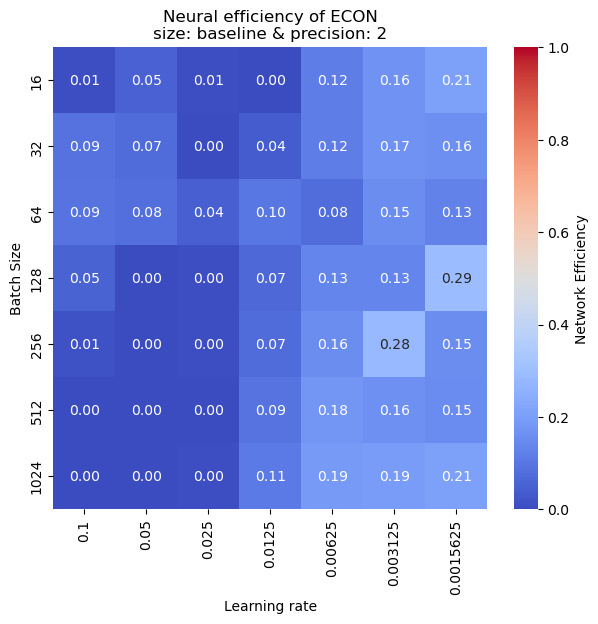

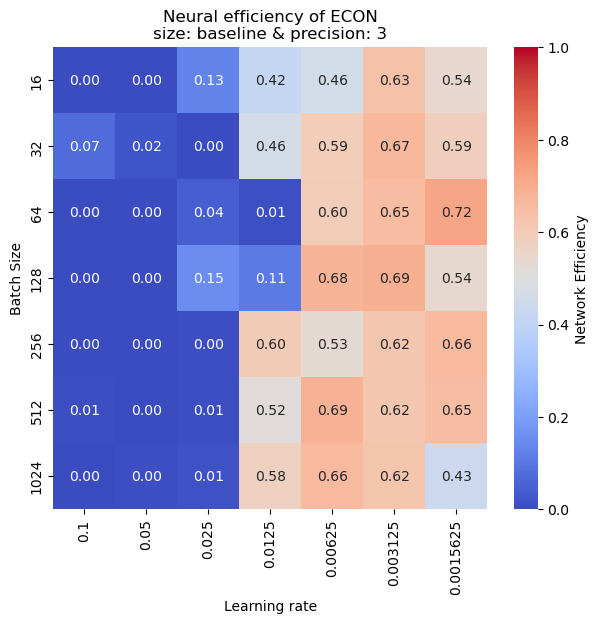

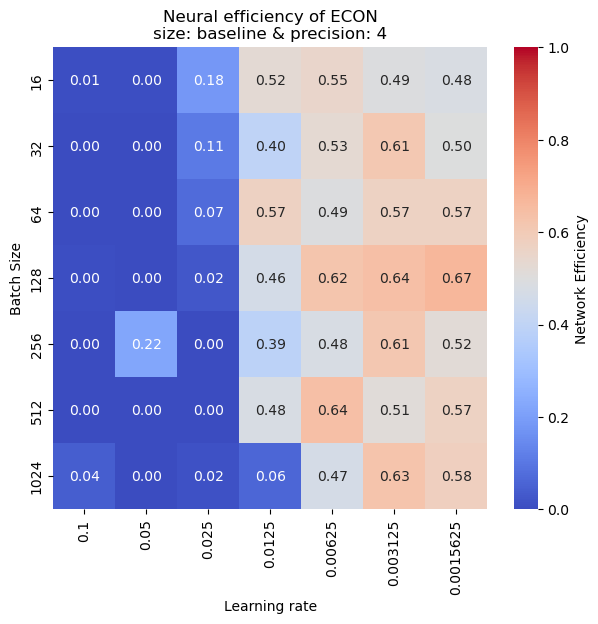

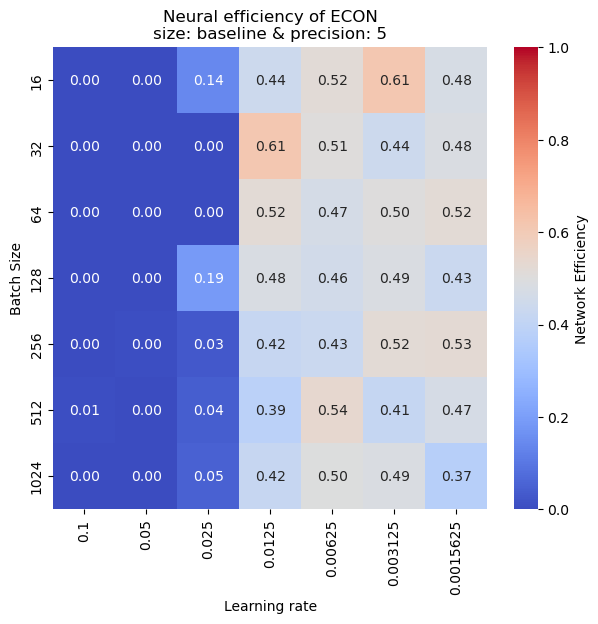

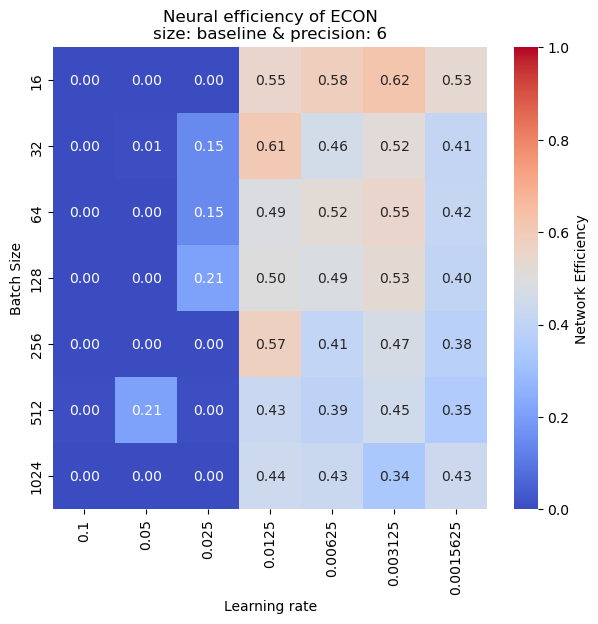

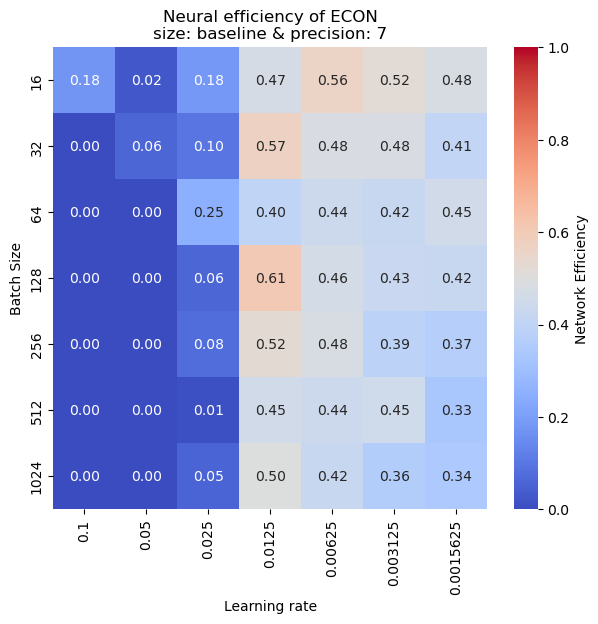

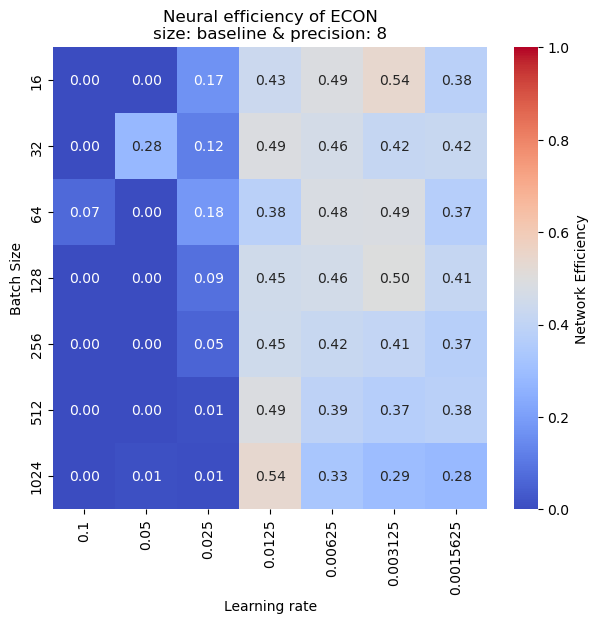

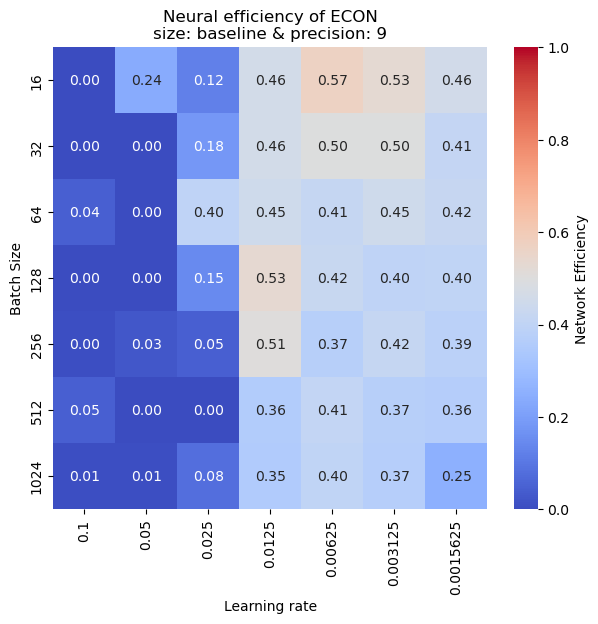

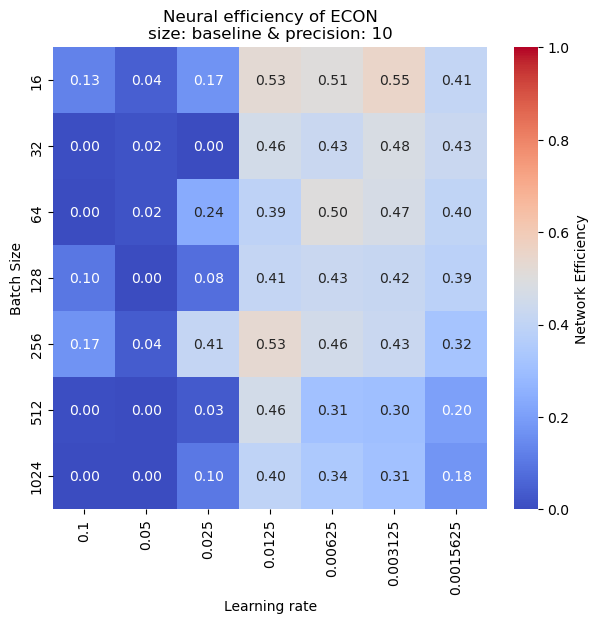

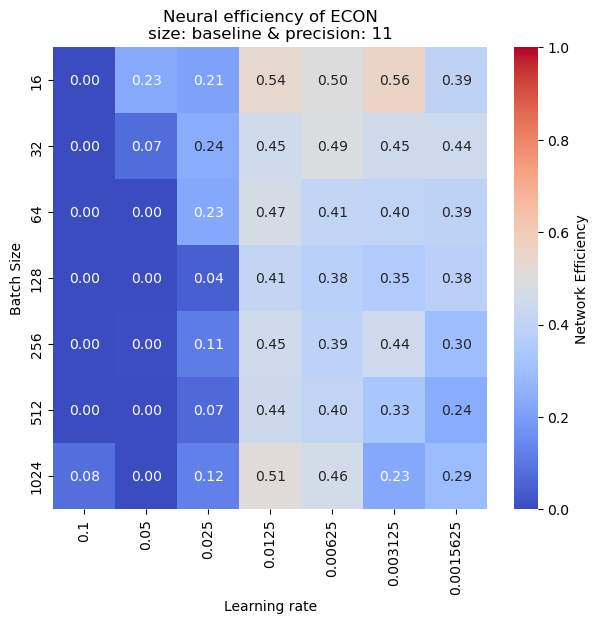

In [23]:
ne_distribution = []
for p in precisions:
    NE_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            
            # get the performances with and without noise
            mean_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            noise_emd = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, noise)
            
            # get the model
            model, _ = econ.load_model(DATA_PATH, bs, lr, p, size)
    
            # instantiate the metric
            metric = NeuralEfficiency(model, 
                                      ne_dataloader, 
                                      performance=mean_emd, 
                                      max_batches=ne_batch_num,
                                      target_layers=ECON_layers)
            
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/ECON_{p}b/{size}/'
            )
            result = -1
            if metric.load_from_file(path):
                result = metric.results['network_efficiency']
            
            # build the heatmap matrix
            NE_matrix[x, y] = result
            
            # build the dataframe for further analysis
            ne_distribution.append({
                'precision': p, 
                'net_efficiency': result,
                'emd': mean_emd,
                'noise_emd': noise_emd,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (noise_emd - mean_emd) * 100 / mean_emd,
            })
            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=batch_sizes, 
                             columns=learning_rates)
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of ECON\nsize: {size} & precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Network Efficiency',
                    cmap='coolwarm')
    

In [24]:
ne_distribution_df = pd.DataFrame(ne_distribution)
# export to csv
ne_distribution_df.to_csv('./results/econ/neural_efficiency.csv', index=False)

The batch size is not correlated with EMD and the noise, so we want to plot it based on the precision

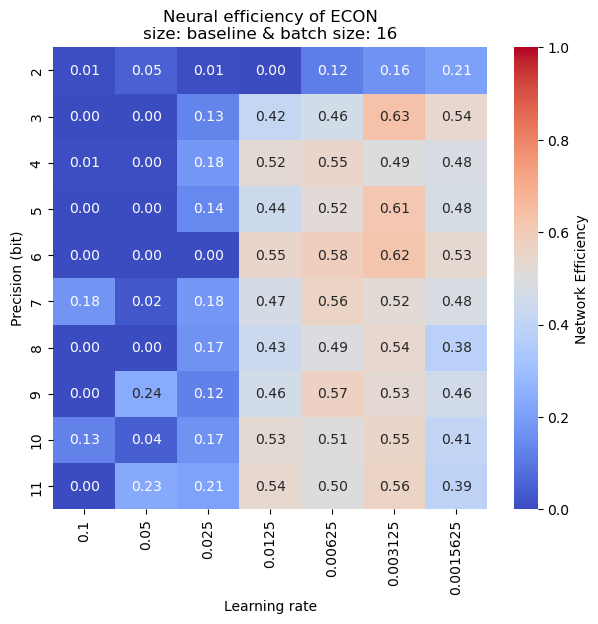

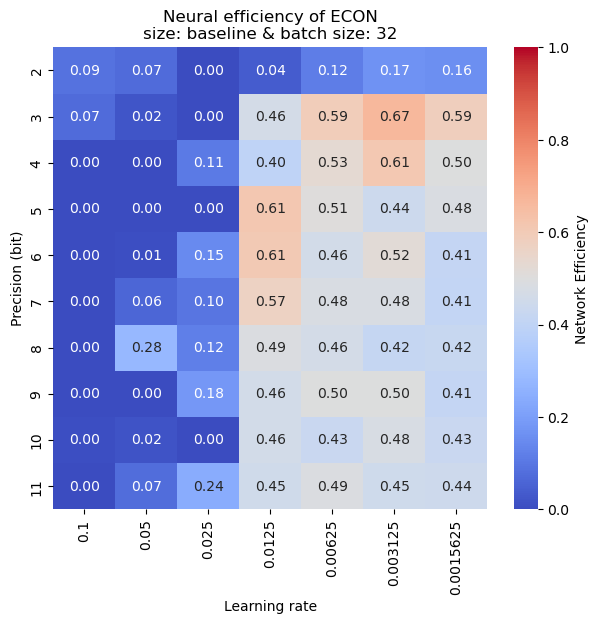

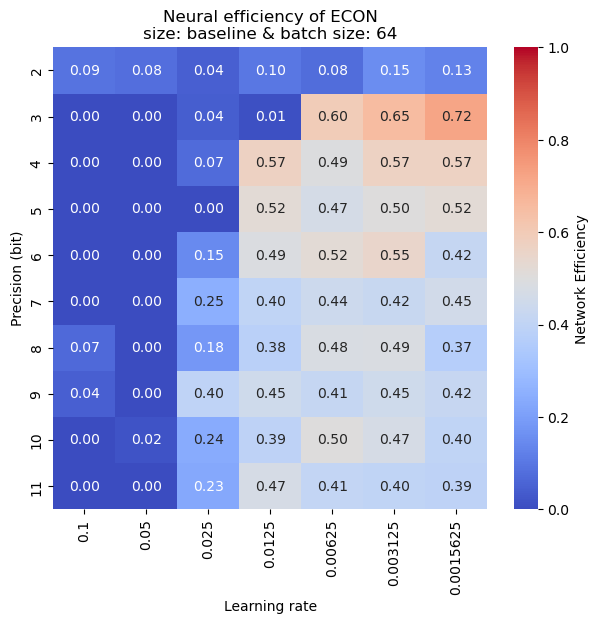

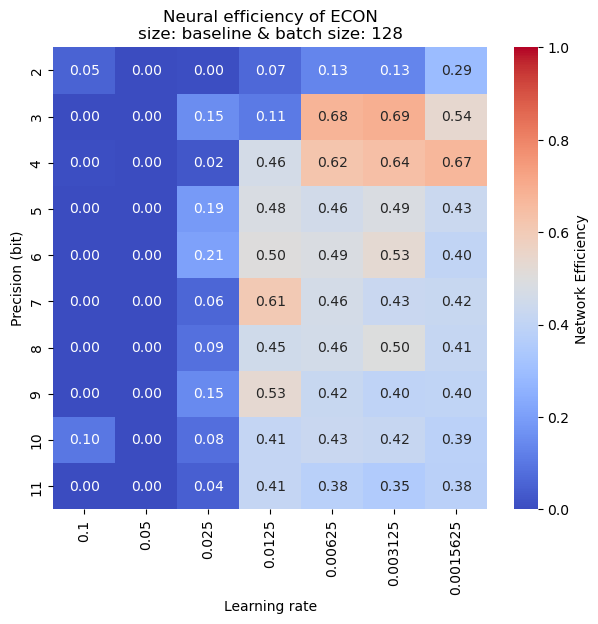

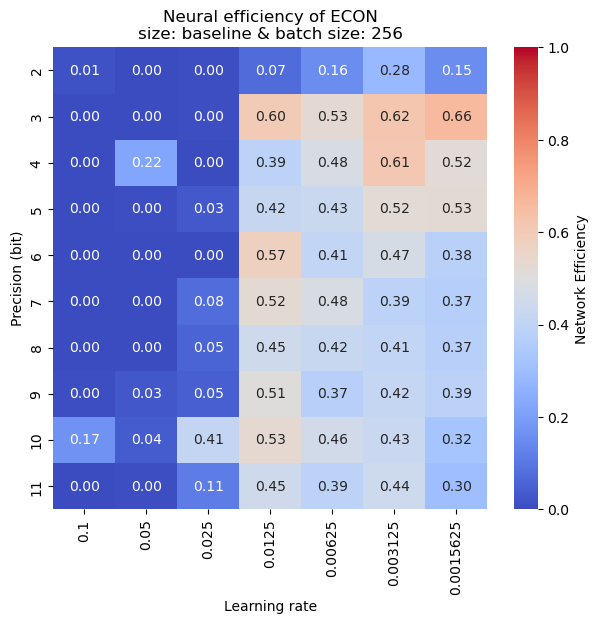

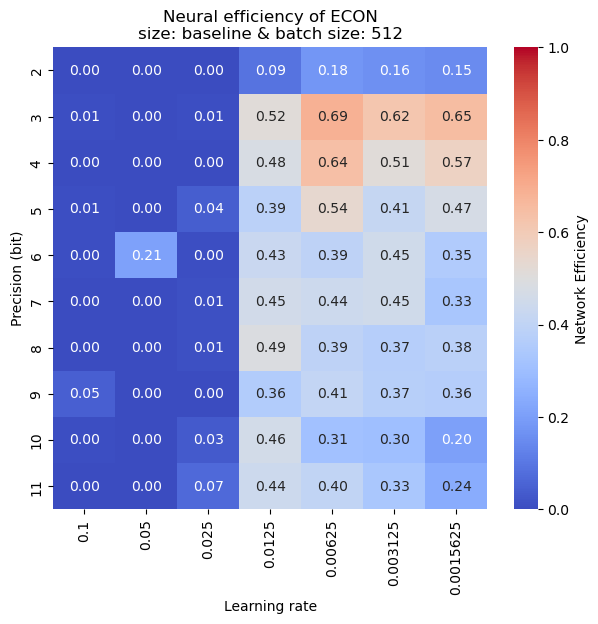

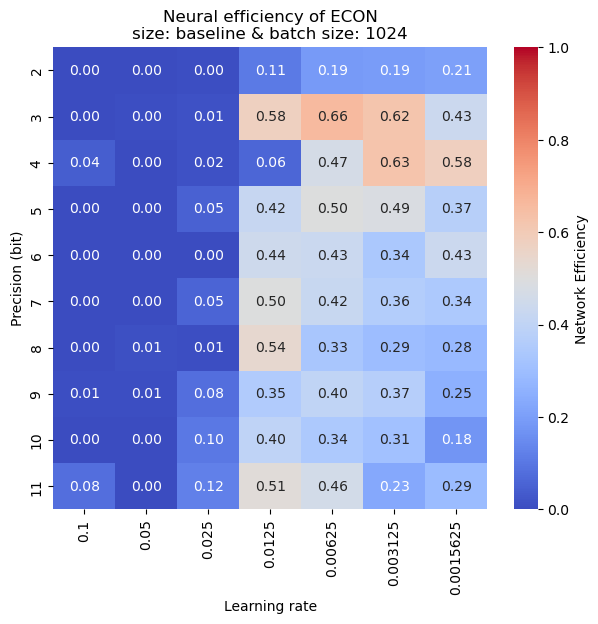

In [25]:

for bs in batch_sizes:
    NE_matrix = np.zeros((len(precisions), len(learning_rates)))

    for y, lr in enumerate(learning_rates):
        for x, p in enumerate(precisions):
            
            # get the performances with and without noise
            mean_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            noise_emd = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, noise)
            
            # get the model
            model, _ = econ.load_model(DATA_PATH, bs, lr, p, size)
    
            # instantiate the metric
            metric = NeuralEfficiency(model, 
                                      ne_dataloader, 
                                      performance=mean_emd, 
                                      max_batches=ne_batch_num,
                                      target_layers=ECON_layers)
            
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/ECON_{p}b/{size}/'
            )
            result = -1
            if metric.load_from_file(path):
                result = metric.results['network_efficiency']
            
            # build the heatmap matrix
            NE_matrix[x, y] = result

            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=precisions, 
                             columns=learning_rates)
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of ECON\nsize: {size} & batch size: {bs}', 
                    (0, 1),
                    'Learning rate',
                    'Precision (bit)',
                    'Network Efficiency',
                    cmap='coolwarm')
    

# RN08 (TinyResNet)

In [26]:
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [27]:
DATA_PATH="/data/tbaldi/work/checkpoint/"   
DATASET_DIR = "/data/tbaldi/work/loss_landscape_taxonomy/data/RN08/"

In [28]:
RN08_layers = [
            'model.conv1', 
            'model.QBlocks.0.conv1', 
            'model.QBlocks.0.conv2', 
            'model.QBlocks.1.conv1', 
            'model.QBlocks.1.conv2',  
            'model.QBlocks.2.conv1', 
            'model.QBlocks.2.conv2',
            'model.QBlocks.2.shortcut',
            'model.QBlocks.3.conv1', 
            'model.QBlocks.3.conv2', 
            'model.QBlocks.4.conv1', 
            'model.QBlocks.4.conv2',
            'model.QBlocks.4.shortcut',
            'model.QBlocks.5.conv1', 
            'model.QBlocks.5.conv2', 
            'model.linear'
        ]

In [29]:
def get_neural_efficiency(batch_size, 
                          learning_rate, 
                          precision,
                          dataloader,
                          load=True,
                          max_batches=None,
                          beta=2):
    '''
    Get the value of the Neural Efficiency
    '''
    
    # path to the directory
    path = os.path.join(
        DATA_PATH, 
        f'bs{batch_size}_lr{learning_rate}/RN08_{precision}b/'
    )
    
    # load the model and the performance
    model, acc = rn08.get_model_and_accuracy(DATA_PATH, 
                                             batch_size, 
                                             learning_rate, 
                                             precision)
    
    # instantiate the metric
    metric = NeuralEfficiency(model, 
                              dataloader, 
                              performance=acc, 
                              max_batches=max_batches,
                              target_layers=RN08_layers)
    
    # try to load the result
    if load:
        if metric.load_from_file(path):
            return metric.results
        else:
            print("Information not stored in ", path)
    
    # compute the result and store it
    result = metric.compute(beta=beta)
    metric.save_on_file(path=path)
    
    return result

In [30]:
_, ne_dataloader, _ = rn08.get_cifar10_loaders(DATASET_DIR, 256)
ne_batch_num = 1000

Files already downloaded and verified


File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/net_1_best.pkl)
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_2b/net_1_best.pkl)
File neural_efficiency.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.025/RN08_2b/net_1_best.pkl)
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.0125/RN08_2b/net_1_best.pkl)
File neural_efficiency.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.05/RN08_2b/net_1_best.pkl)
File not found! (/data/tbaldi/work/checkpoint/bs128_lr0.00625/RN08_2b/net_1_best.pkl)
File neural_efficiency.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs256_lr0.003125/RN08_2b/net_1_best.pkl)
File not found! (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_2b/net_1_best.pkl)
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.003125/RN08_2b/net_1_best.pkl)
File not found! (/data/tbaldi/work/checkpoin

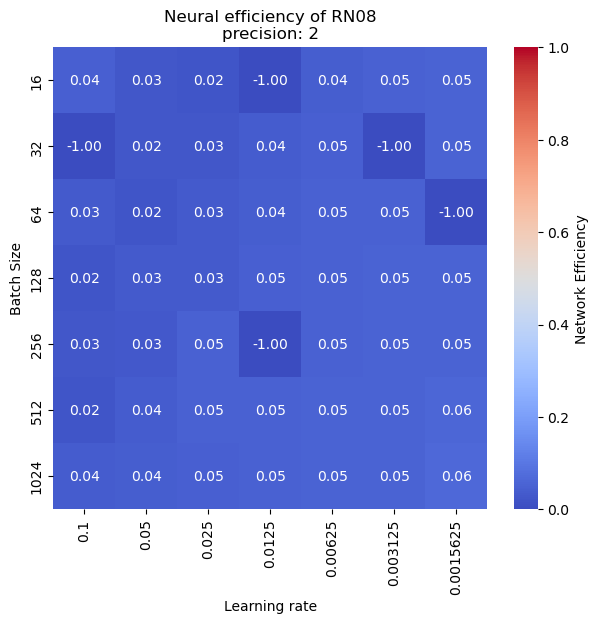

File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!


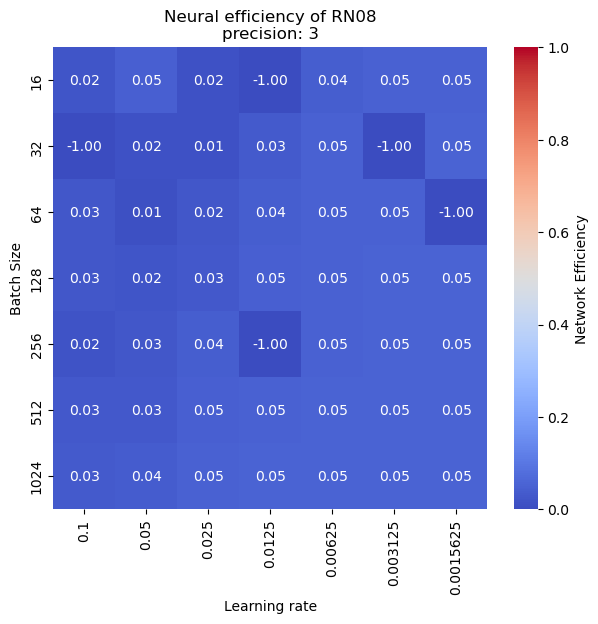

File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_4b/net_1_best.pkl)


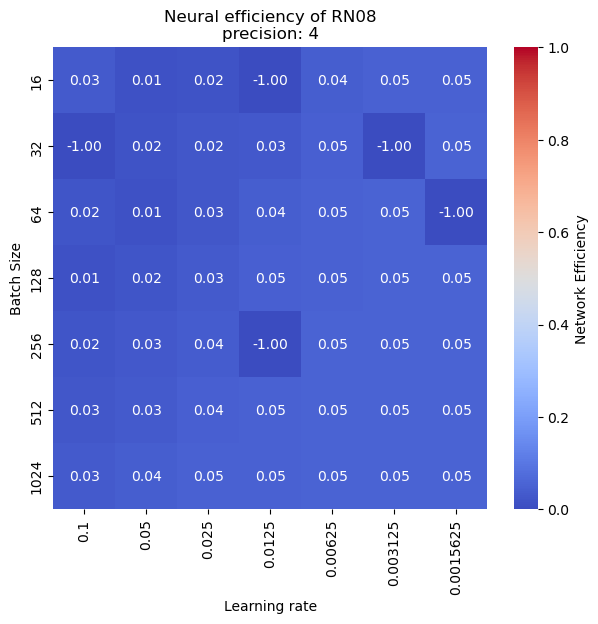

File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!


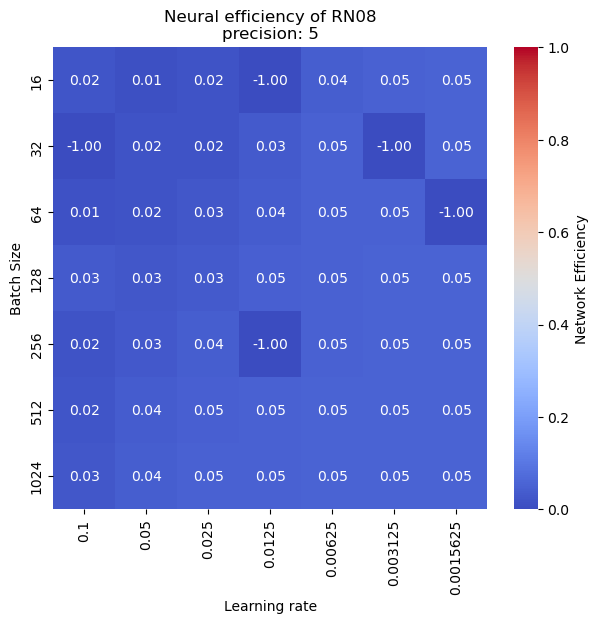

File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_6b/net_1_best.pkl)


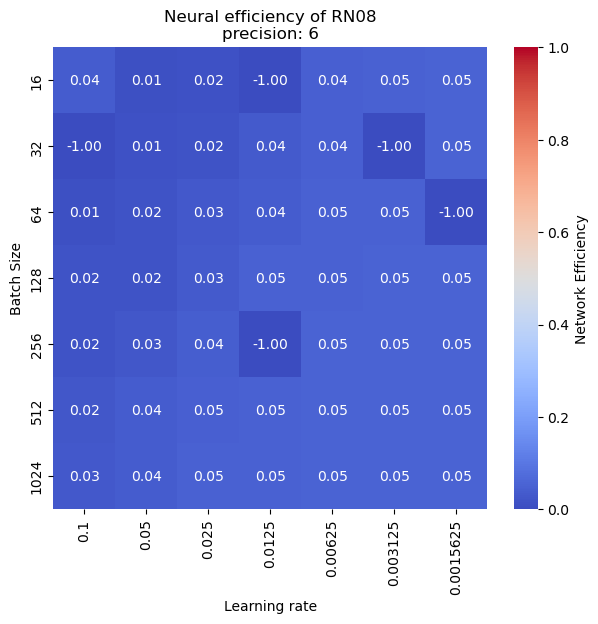

File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_7b/net_1_best.pkl)


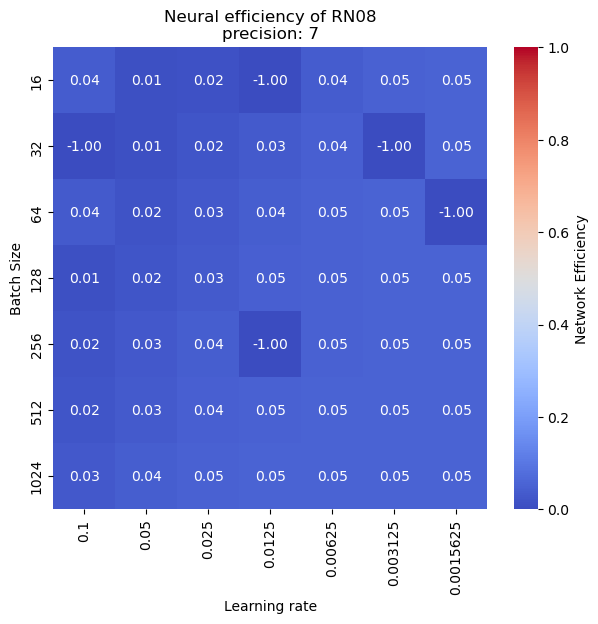

File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!


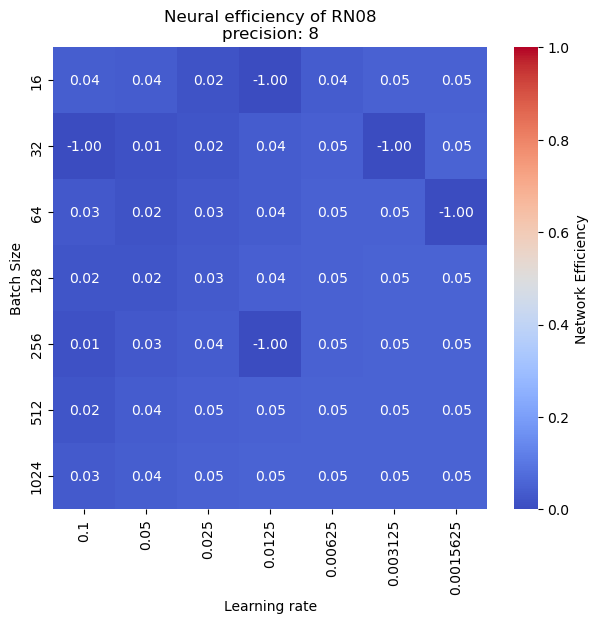

File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!


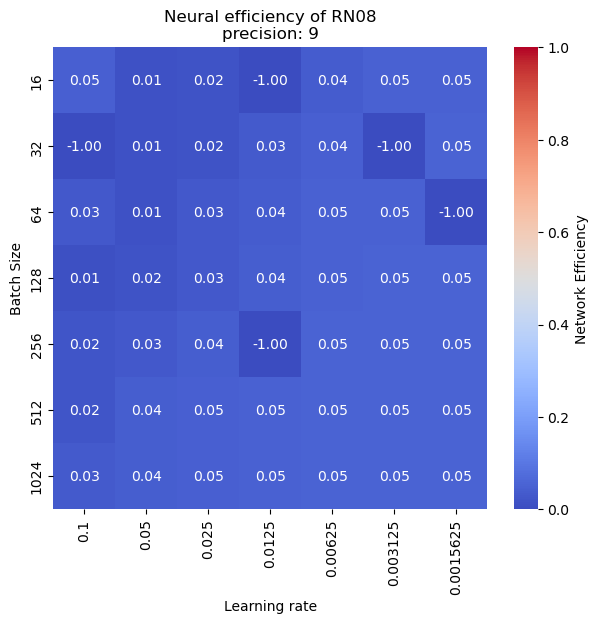

File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!


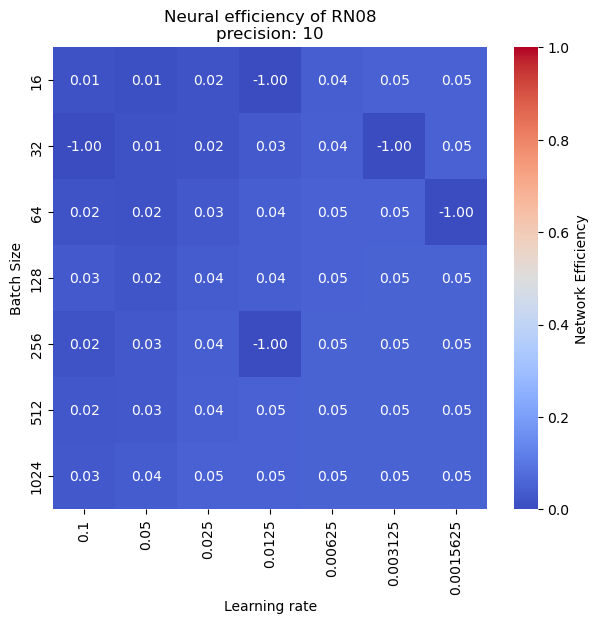

File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File neural_efficiency.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_11b/net_1_best.pkl)


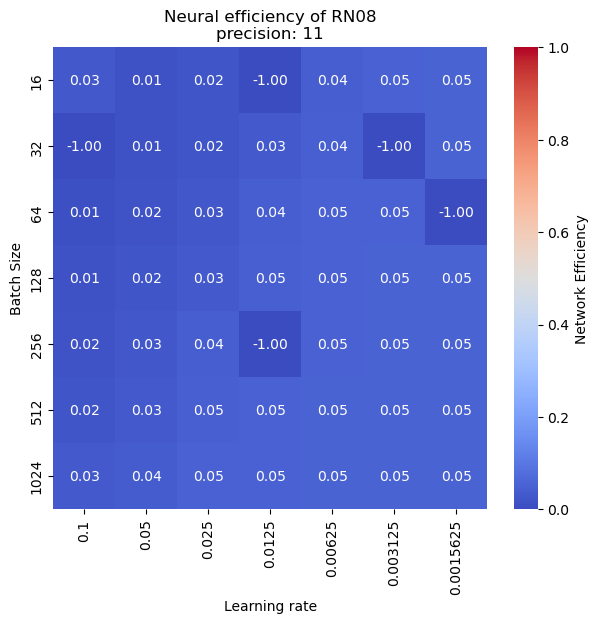

In [31]:
ne_distribution = []
for p in precisions:
    NE_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            
            # get the performances with and without noise
            model, acc = rn08.get_model_and_accuracy(DATA_PATH, 
                                                     bs, 
                                                     lr, 
                                                     p)
            
            # instantiate the metric
            metric = NeuralEfficiency(model, 
                                      ne_dataloader, 
                                      performance=acc, 
                                      max_batches=ne_batch_num,
                                      target_layers=RN08_layers)
            
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/RN08_{p}b/'
            )
            
            result = -1
            if metric.load_from_file(path):
                result = metric.results['network_efficiency']
                        
            # build the heatmap matrix
            NE_matrix[x, y] = result
            
            # build the dataframe for further analysis
            ne_distribution.append({
                'precision': p, 
                'net_efficiency': result,
                'accuracy': acc,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=batch_sizes, 
                             columns=learning_rates)
    
    
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of RN08\nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Network Efficiency',
                    cmap='coolwarm')

In [32]:
ne_distribution_df = pd.DataFrame(ne_distribution)
ne_distribution_df.to_csv("./results/rn08/neural_efficiency.csv", index=False)